## Part 1: Iterative Reweighted Least Squares optimization algorithm for logistic regression

In [1]:
import pandas as pd
from functools import partial
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np

class LogReg():
    def __init__(self):
        self.W = []
        self.score = []
        self.accuracy = []
        self.interactions = []

    def sigmoid(self, X, W):
        return 1 / (1 + np.exp(-X @ W))  # X(n,f) W(f,1)

    def fit(self, X, y, iter=100, eps=1e-2, interactions=[]):
        self.interactions = interactions
        for interaction in interactions:
            X = np.c_[X, X[:, interaction[0] + 1] * X[:, interaction[1] + 1]]
        n, f = X.shape
        W = np.transpose(np.random.uniform(size=f))
        delta  = 1
        i=0

        while i<iter and delta > eps:
            p = self.sigmoid(X,W)
            B = np.diag( p*(1-p) )
            H = np.transpose(X) @ B @ X  # H(f,f)
            grad = np.transpose(X) @ (np.expand_dims(p, axis=1)- np.expand_dims(y, axis=1))
            W_next = np.expand_dims(W, axis=1) - np.linalg.pinv(H) @ grad
            delta = np.linalg.norm(W_next - W)
            W = W_next
            W = W.reshape(-1)
            self.score.append(W)
            i += 1
#             if i == iter:
#                 print("no")
        self.W = W
        return W

    def predict(self, X, y_true):
        for interaction in self.interactions:
            X = np.c_[X, X[:, interaction[0] + 1] * X[:, interaction[1] + 1]]
        for w in lr.score:
            y_pre = ( self.sigmoid(X,w) > 0.5 ).astype(int)
            self.accuracy.append( accuracy_score(y_true, y_pre) )
        return y_pre

## Part 3: Real Datasets Experiment

### 3.1: Datasets

#### Dataset 1: SAheart.data (South African Heart Disease) 
This is a dataset containing information about patients in Age between 15 and 64. Target variable chd indicates the presence of myocardial infarction. 

In [3]:
df = pd.read_csv("SAheart.data")
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [4]:
# check for missing values
print('The number of missing values in the dataset is:', df.isnull().sum().sum())

The number of missing values in the dataset is: 0


In [5]:
# check dtypes of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  462 non-null    int64  
 1   sbp        462 non-null    int64  
 2   tobacco    462 non-null    float64
 3   ldl        462 non-null    float64
 4   adiposity  462 non-null    float64
 5   famhist    462 non-null    object 
 6   typea      462 non-null    int64  
 7   obesity    462 non-null    float64
 8   alcohol    462 non-null    float64
 9   age        462 non-null    int64  
 10  chd        462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


As can be seen, we have one categorical feature 'famhist' that needs to be converted to numerical.

In [6]:
df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0}) # converting categorical var

In [7]:
X = df.drop('chd', axis=1)
y = df['chd'] # target variable

In [8]:
import statsmodels.api as sm

def calculate_vif(X):
    X_matrix = np.array(X)
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [sm.OLS(X_matrix[:, i], sm.add_constant(X_matrix[:, ~np.isin(np.arange(X.shape[1]), i)])).fit().rsquared for i in range(X.shape[1])]
    return vif

# removing collinear variables with VIF > threshold
def collinear(X, threshold=10):
    vif = calculate_vif(X)
    cols_to_drop = vif[vif['VIF'] > threshold]['Features']
    X_new = X.drop(cols_to_drop, axis=1)
    return X_new

X_new = collinear(X)

In [9]:
from sklearn.preprocessing import StandardScaler

# standardizing data
sc = StandardScaler().fit(X_new)
X = sc.transform(X_new)

In [10]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)

#### Dataset 2: Water Potability
This is a dataset containing water quality metrics for 3276 different water bodies.

In [11]:
df2 = pd.read_csv("water.csv")
df2.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
# check for missing values
print('The number of missing values in the dataset is:', df2.isnull().sum().sum())

The number of missing values in the dataset is: 1434


In [13]:
# drop missing values
df2.dropna(inplace=True)

In [14]:
# check dtypes of features
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


In [15]:
X2 = df2.drop('Potability', axis=1)
y2 = df2['Potability'] # target variable

In [16]:
# remove collinear vars
X_new2 = collinear(X2)

In [29]:
# standardizing data
sc = StandardScaler().fit(X_new2)
X2 = sc.transform(X_new2)

# train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

### 3.2: Compare the classification performance of implemented logistic regression with available implementations of this model and 3 popular classification methods: LDA, QDA and KNN. Use at least 3 evaluation metrics.

#### Dataset 1. Experiments:

In [19]:
# our implementation: LR with interactions
lr = LogReg()
lr.fit(X=X_train, y = y_train, interactions=[[0,1]])
y_pred = lr.predict(X_test,y_test)
myAcc = accuracy_score(y_test, y_pred)
myPrecision = precision_score(y_test, y_pred)
myRecall = recall_score(y_test, y_pred)

print('Accuracy: ', myAcc)
print('Precision: ', myPrecision)
print('Recall: ', myRecall)

Accuracy:  0.46236559139784944
Precision:  0.35185185185185186
Recall:  0.5588235294117647


In [20]:
# fitting models
logistic = LogisticRegression().fit(X_train, y_train)
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

# predictions
lr_preds = logistic.predict(X_test)
lda_preds = lda.predict(X_test)
qda_preds = qda.predict(X_test)
knn_preds = knn.predict(X_test)

# metric 1: accuracy
lr_acc = accuracy_score(y_test, lr_preds)
lda_acc = accuracy_score(y_test, lda_preds)
qda_acc = accuracy_score(y_test, qda_preds)
knn_acc = accuracy_score(y_test, knn_preds)

# metric 2: precision
lr_precision = precision_score(y_test, lr_preds)
lda_precision = precision_score(y_test, lda_preds)
qda_precision = precision_score(y_test, qda_preds)
knn_precision = precision_score(y_test, knn_preds)

# metric 3: recall
lr_recall = recall_score(y_test, lr_preds)
lda_recall = recall_score(y_test, lda_preds)
qda_recall = recall_score(y_test, qda_preds)
knn_recall = recall_score(y_test, knn_preds)

In [21]:
# dataset 1 results
data = {'Model': ['Implemented LR', 'Sklearn.LR', 'LDA', 'QDA', 'KNN'],
        'Accuracy': [myAcc, lr_acc, lda_acc, qda_acc, knn_acc],
        'Precision': [myPrecision, lr_precision, lda_precision, qda_precision, knn_precision],
        'Recall': [myRecall, lr_recall, lda_recall, qda_recall, knn_recall]}

res = pd.DataFrame(data)
res

,Model,Accuracy,Precision,Recall
0,Implemented LR,0.462366,0.351852,0.558824
1,Sklearn.LR,0.784946,0.791667,0.558824
2,LDA,0.763441,0.750000,0.529412
3,QDA,0.741935,0.692308,0.529412
4,KNN,0.655914,0.555556,0.294118


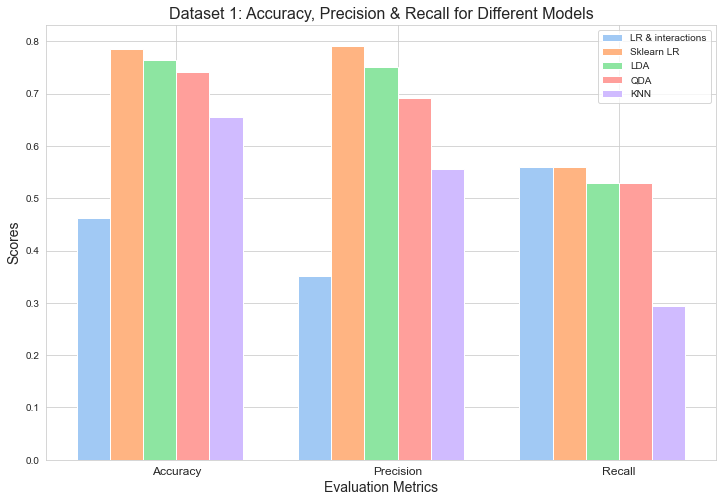

In [22]:
sns.set_style("whitegrid")

models = ['Accuracy', 'Precision', 'Recall']
myLr_scores = [myAcc, myPrecision, myRecall]
lr_scores = [lr_acc, lr_precision, lr_recall]
lda_scores = [lda_acc, lda_precision, lda_recall]
qda_scores = [qda_acc, qda_precision, qda_recall]
knn_scores = [knn_acc, knn_precision, knn_recall]

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.15
x = np.arange(len(models))

model1 = ax.bar(x, myLr_scores, width, label='LR & interactions')
model2 = ax.bar(x + width, lr_scores, width, label='Sklearn LR')
model3 = ax.bar(x + 2*width, lda_scores, width, label='LDA')
model4 = ax.bar(x + 3*width, qda_scores, width, label='QDA')
model5 = ax.bar(x + 4*width, knn_scores, width, label='KNN')

ax.set_xlabel('Evaluation Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Dataset 1: Accuracy, Precision & Recall for Different Models', fontsize=16)
ax.set_xticks(x + 2.5*width)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=10)

plt.show()

#### Dataset 2. Experiments:

In [32]:
# our implementation: LR with interactions
lr = LogReg()
lr.fit(X=X_train2, y = y_train2, interactions=[[0,1]])
y_pred = lr.predict(X_test2,y_test2)
myAccDf2 = accuracy_score(y_test2, y_pred)
myPrecisionDf2 = precision_score(y_test2, y_pred)
myRecallDf2 = recall_score(y_test2, y_pred)

print('Accuracy: ', myAccDf2)
print('Precision: ', myPrecisionDf2)
print('Recall: ', myRecallDf2)

Accuracy:  0.46357615894039733
Precision:  0.38170347003154576
Recall:  0.4859437751004016


In [30]:
# fitting models
myLr2 = LogisticRegression().fit(X_train2, y_train2)
lda = LinearDiscriminantAnalysis().fit(X_train2, y_train2)
qda = QuadraticDiscriminantAnalysis().fit(X_train2, y_train2)
knn = KNeighborsClassifier().fit(X_train2, y_train2)

# predictions
lr_preds = myLr2.predict(X_test2)
lda_preds = lda.predict(X_test2)
qda_preds = qda.predict(X_test2)
knn_preds = knn.predict(X_test2)

# metric 1: accuracy
lr_acc = accuracy_score(y_test2, lr_preds)
lda_acc = accuracy_score(y_test2, lda_preds)
qda_acc = accuracy_score(y_test2, qda_preds)
knn_acc = accuracy_score(y_test2, knn_preds)

# metric 2: precision
lr_precision = precision_score(y_test2, lr_preds)
lda_precision = precision_score(y_test2, lda_preds)
qda_precision = precision_score(y_test2, qda_preds)
knn_precision = precision_score(y_test2, knn_preds)

# metric 3: recall
lr_recall = recall_score(y_test2, lr_preds)
lda_recall = recall_score(y_test2, lda_preds)
qda_recall = recall_score(y_test2, qda_preds)
knn_recall = recall_score(y_test2, knn_preds)

In [31]:
# dataset 2 results
data2 = {'Model': ['Implemented LR', 'Sklearn.LR', 'LDA', 'QDA', 'KNN'],
        'Accuracy': [myAccDf2, lr_acc, lda_acc, qda_acc, knn_acc],
        'Precision': [myPrecisionDf2, lr_precision, lda_precision, qda_precision, knn_precision],
        'Recall': [myRecallDf2, lr_recall, lda_recall, qda_recall, knn_recall]}

res2 = pd.DataFrame(data2)
res2

,Model,Accuracy,Precision,Recall
0,Implemented LR,0.533499,0.459596,0.529070
1,Sklearn.LR,0.596026,0.777778,0.028112
2,LDA,0.596026,0.777778,0.028112
3,QDA,0.678808,0.684564,0.409639
4,KNN,0.630795,0.575581,0.397590


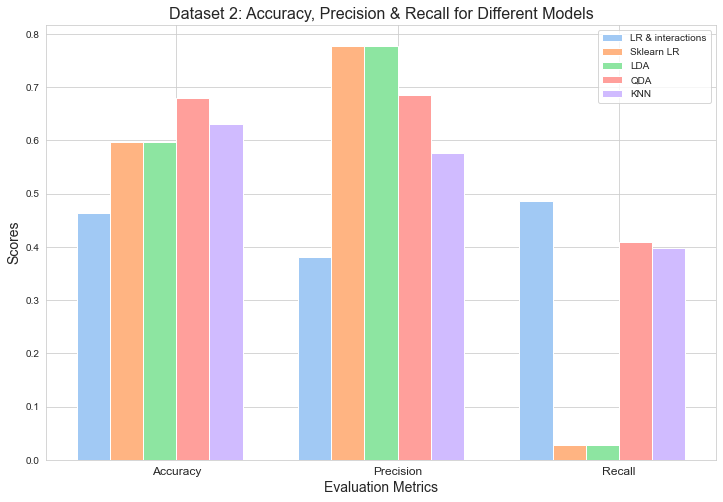

In [33]:
sns.set_style("whitegrid")

models = ['Accuracy', 'Precision', 'Recall']
myLr_scores = [myAccDf2, myPrecisionDf2, myRecallDf2]
lr_scores = [lr_acc, lr_precision, lr_recall]
lda_scores = [lda_acc, lda_precision, lda_recall]
qda_scores = [qda_acc, qda_precision, qda_recall]
knn_scores = [knn_acc, knn_precision, knn_recall]

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.15
x = np.arange(len(models))

model1 = ax.bar(x, myLr_scores, width, label='LR & interactions')
model2 = ax.bar(x + width, lr_scores, width, label='Sklearn LR')
model3 = ax.bar(x + 2*width, lda_scores, width, label='LDA')
model4 = ax.bar(x + 3*width, qda_scores, width, label='QDA')
model5 = ax.bar(x + 4*width, knn_scores, width, label='KNN')

ax.set_xlabel('Evaluation Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Dataset 2: Accuracy, Precision & Recall for Different Models', fontsize=16)
ax.set_xticks(x + 2.5*width)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=10)

plt.show()

### 3.3: The performance of the model with and without interactions

#### Dataset 1

In [34]:
# our implementation: LR with interactions
lr = LogReg()
lr.fit(X=X_train, y = y_train, interactions=[[0,1]])
y_pred = lr.predict(X_test,y_test)
myAcc = accuracy_score(y_test, y_pred)
myPrecision = precision_score(y_test, y_pred)
myRecall = recall_score(y_test, y_pred)

# our implementation: LR without interactions
lr = LogReg()
lr.fit(X=X_train, y = y_train)
y_pred = lr.predict(X_test,y_test)
myAcc2 = accuracy_score(y_test, y_pred)
myPrecision2 = precision_score(y_test, y_pred)
myRecall2 = recall_score(y_test, y_pred)

# df with results
dataset1 = {'Model': ['LR with interactions', 'LR without interactions'],
        'Accuracy': [myAcc, myAcc2],
        'Precision': [myPrecision, myPrecision2],
        'Recall': [myRecall, myRecall2]}

heart = pd.DataFrame(dataset1)
heart

,Model,Accuracy,Precision,Recall
0,LR with interactions,0.559140,0.410256,0.470588
1,LR without interactions,0.677419,0.545455,0.705882


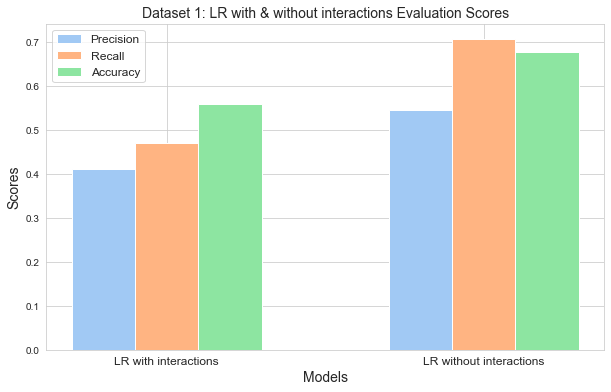

In [36]:
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.2
x = heart.index

precision = ax.bar(x - width, heart['Precision'], width, label='Precision')
recall = ax.bar(x, heart['Recall'], width, label='Recall')
accuracy = ax.bar(x + width, heart['Accuracy'], width, label='Accuracy')

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Dataset 1: LR with & without interactions Evaluation Scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(heart['Model'], fontsize=12)
ax.legend(fontsize=12)
plt.show()

#### Dataset 2

In [37]:
# our implementation: LR with interactions
lr = LogReg()
lr.fit(X=X_train2, y = y_train2, interactions=[[0,1]])
y_pred = lr.predict(X_test2,y_test2)
myAcc = accuracy_score(y_test2, y_pred)
myPrecision = precision_score(y_test2, y_pred)
myRecall = recall_score(y_test2, y_pred)

# our implementation: LR without interactions
lr = LogReg()
lr.fit(X=X_train2, y = y_train2)
y_pred = lr.predict(X_test2,y_test2)
myAcc2 = accuracy_score(y_test2, y_pred)
myPrecision2 = precision_score(y_test2, y_pred)
myRecall2 = recall_score(y_test2, y_pred)

# df with results
dataset2 = {'Model': ['LR with interactions', 'LR without interactions'],
        'Accuracy': [myAcc, myAcc2],
        'Precision': [myPrecision, myPrecision2],
        'Recall': [myRecall, myRecall2]}

water = pd.DataFrame(dataset2)
water

,Model,Accuracy,Precision,Recall
0,LR with interactions,0.476821,0.391586,0.485944
1,LR without interactions,0.504967,0.416107,0.497992


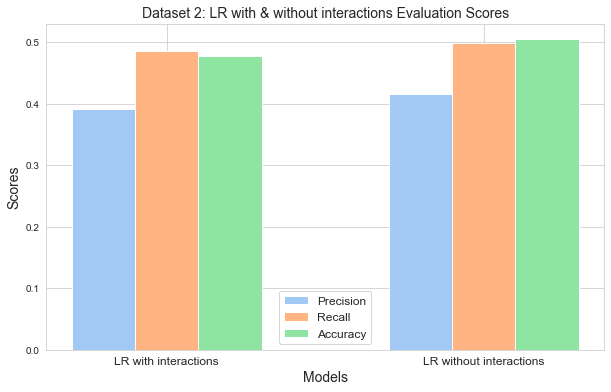

In [38]:
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.2
x = water.index

precision = ax.bar(x - width, water['Precision'], width, label='Precision')
recall = ax.bar(x, water['Recall'], width, label='Recall')
accuracy = ax.bar(x + width, water['Accuracy'], width, label='Accuracy')

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Dataset 2: LR with & without interactions Evaluation Scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(water['Model'], fontsize=12)
ax.legend(fontsize=12)
plt.show()